# TODO 

### use 100's of clusters and keep most important only ? 
### name cluster with 3 most important/frequent labels ( helps for interpretability) => no, confusing. But needs to offer possibility to go into details:
show other features' labels in opinions bar charts. First, just in title. then, in legend and use stacked color bar charts (max 3 + others) 

show pre_clustering FOPs ( bar graph ) 

In [1]:
wdir="AM_videogames/"
chosen_game='diablo III'
game_list= ['diablo III', 'God of War III', 'The Last of Us', 'Mario Kart',
       'StarCraft II: Wings of Liberty']

In [2]:
######################### imports external libraries ##########################
from joblib import dump, load
import pandas as pd
import numpy as np
import csv
from sklearn import cluster
from os import path
import time
import pickle
import nltk
import spacy
import os
import matplotlib.pyplot as plt
import operator
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn import preprocessing

sp_md_vector = spacy.load('en_core_web_md',disable=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])
sp_md = spacy.load('en_core_web_md')


## Read csv FOPs

In [3]:
from FOPs import read_FOPs_csv
filepath=wdir+chosen_game+"_parser_FOPs.csv"
FOPs_df=read_FOPs_csv(wdir+"diablo III_parser_FOPs.csv")
print(FOPs_df.shape)
FOPs_df.head(20)

FOPs_df = FOPs_df.sort_values('abs_importance', ascending=False)
FOPs_df.head(20)

(1797, 6)


,feature,opinion,count,importance,polarity,abs_importance
1,game,great,58,36.2442,0.624900,36.2442
3,game,good,35,15.4140,0.440400,15.4140
2,game,fun,36,14.7300,0.409167,14.7300
7,reviews,negative,14,-8.0066,-0.571900,8.0066
20,fun,great,8,4.9992,0.624900,4.9992
15,game,awesome,8,4.9992,0.624900,4.9992
13,graphics,good,10,4.4040,0.440400,4.4040
12,graphics,better,10,4.4040,0.440400,4.4040
39,experience,great,6,3.7494,0.624900,3.7494
24,items,better,8,3.5232,0.440400,3.5232


## extract features vectors

In [15]:
features=FOPs_df.groupby(["feature"]).size().reset_index(name='count').sort_values('count', 
                                                        ascending=False).reset_index(drop=True)
# features=features.groupby(["feature"]).size().reset_index(name='counts').sort_values('importance', 
#                                                         ascending=False).reset_index(drop=True)[:500]
F_list=list(features.feature.unique())
print(len(F_list), " features")
O_list=list(FOPs_df.opinion.unique())
print(len(O_list), " opinions")

sp_F_vectors=sp_md_vector(" ".join(F_list))
len(sp_F_vectors)
fv_dict={}
v_list=[]
for token in sp_F_vectors:
    fv_dict[token.text]=token.vector
    v_list.append(token.vector)
    
# v_list=preprocessing.normalize(v_list)
# features

features["abs_importance"]=features["count"]
for feature in features.iterrows():
#     print(feature[0],feature[1][0],feature[1][1])
    features.at[feature[0],"abs_importance"]=FOPs_df.loc[FOPs_df['feature'] == feature[1][0]]["abs_importance"].sum()
# features=features.loc[features["abs_importance"] >=20]
features.sort_values('abs_importance', ascending=False).reset_index(drop=True).head(20)
# features.shape

727  features
862  opinions


,feature,count,abs_importance
0,game,116,129
1,graphics,16,18
2,reviews,7,13
3,thing,18,11
4,gear,11,11
5,story,15,8
6,system,18,7
7,games,27,7
8,items,30,7
9,fun,10,7


## Elbow curve for Kmeans with sum of square or silhouette

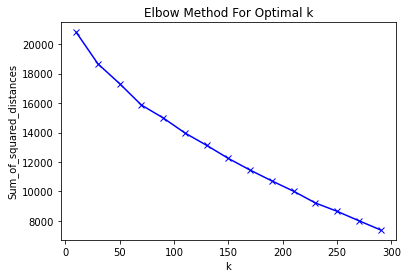

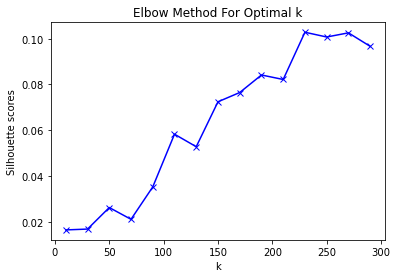

In [16]:
Sum_of_squared_distances = []
silhouette=[]
K = range(10,300,20)
for k in K:
    print(int(k/100*100) , " % processed", end="\r", flush=True)
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(v_list)
    Sum_of_squared_distances.append(km.inertia_)
    labels = km.labels_
    silhouette.append(metrics.silhouette_score(v_list, labels))
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette scores')
plt.title('Elbow Method For Optimal k')
plt.show()

## Kmeans and identify names for labels (most numerous feature in the cluster)
### add to the df

In [6]:
def internalIndices(labels=None, features_list=None):
    sil_score = metrics.silhouette_score(features_list, labels, metric='euclidean')
    calinski_score = metrics.calinski_harabasz_score(features_list, labels)
    davies_score = metrics.davies_bouldin_score(features_list, labels)
    return list((sil_score, calinski_score, davies_score))


def Kmeans(features_list=None, n_clusters=None):
    kmeans_model = cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(features_list)
    labels = kmeans_model.labels_
    sil_score, calinski_score, davies_score = internalIndices(labels=labels, features_list=features_list)
    return kmeans_model, sil_score, calinski_score, davies_score

def AffinityPropagation(features_list=None, n_clusters=None):
    model=cluster.AffinityPropagation(random_state=5).fit(features_list)
    labels = model.labels_
    sil_score, calinski_score, davies_score = internalIndices(labels=labels, features_list=features_list)
    return model, sil_score, calinski_score, davies_score


In [7]:

# # model, sil, cal, davies = Kmeans(features_list=v_list, n_clusters=n_clusters)
# model, sil, cal, davies =AffinityPropagation(v_list)
# n_clusters=len(model.cluster_centers_indices_)
# print(len(model.cluster_centers_indices_))
# labels_dict={}
# for k in range(n_clusters):
#     labels_dict[k]={}
    
# print(len(sp_F_vectors))
# for token in sp_F_vectors:
# #     array
#     label_id=model.predict([token.vector])
#     labels_dict[label_id[0]][token.text]= int(features.loc[features['feature'] == token.text]["count"])
    
# labels={}
# sum(sum(c.values()) for c in labels_dict.values())
# for key,values in labels_dict.items():
#     most_common_feature=max(values.items(), key=operator.itemgetter(1))[0]
#     label_count=sum(values.values())
#     labels[key]=(most_common_feature,label_count)

    
# FOPs_df["label"]=FOPs_df["feature"]
# for token in sp_F_vectors:
# #     array
#     label_id=model.predict([token.vector])
#     FOPs_df["label"] = np.where((FOPs_df.feature == token.text),labels[label_id[0]][0],FOPs_df.label)
# FOPs_df.head(100)
# labels
# print(sil,cal,davies)

In [17]:

n_clusters=230
model, sil, cal, davies = Kmeans(features_list=v_list, n_clusters=n_clusters)
# model, sil, cal, davies =AffinityPropagation(v_list)
# n_clusters=len(model.cluster_centers_indices_)
labels_dict={}
for k in range(n_clusters):
    labels_dict[k]={}
    
print(len(sp_F_vectors))
for token in sp_F_vectors:
#     array
    label_id=model.predict([token.vector])
    labels_dict[label_id[0]][token.text]= int(features.loc[features['feature'] == token.text]["count"])
    
labels={}
sum(sum(c.values()) for c in labels_dict.values())
for key,values in labels_dict.items():
    most_common_feature=max(values.items(), key=operator.itemgetter(1))[0]
    label_count=sum(values.values())
    labels[key]=(most_common_feature,label_count)

    
FOPs_df["label"]=FOPs_df["feature"]
for token in sp_F_vectors:
#     array
    label_id=model.predict([token.vector])
    FOPs_df["label"] = np.where((FOPs_df.feature == token.text),labels[label_id[0]][0],FOPs_df.label)
FOPs_df.head(100)
# labels
print(sil,cal,davies)


727
0.094905026 3.510378570848746 1.3517970852129726


In [18]:
labels
sort_labels = sorted(labels.items(), key=lambda x: x[1][1], reverse=True)
sort_labels
# for i in sort_labels:
#     print(i[0], i[1])
for elem in sort_labels:
    labels_dict
    labels_dict[elem[1][0]] = labels_dict.pop(elem[0])

In [19]:
Features_df=FOPs_df[["count","importance","label"]].groupby(["label"]).head().sort_values('importance', ascending=False).reset_index(drop=True)
Features_df=Features_df.head()
Features_df.head()

,count,importance,label
0,58,36.2442,game
1,35,15.4140,game
2,36,14.7300,game
3,8,4.9992,thing
4,8,4.9992,game


# grouping opinions on different clusters 

In [20]:
labels_dict

{'game': {'game': 116, 'games': 27},
 'people': {'people': 13,
  'way': 11,
  'ones': 8,
  'part': 7,
  'one': 6,
  'work': 4,
  'end': 4,
  'in': 4,
  'person': 3,
  'men': 3,
  'old': 2,
  'for': 2,
  'place': 2,
  'plan': 2,
  'waste': 2,
  'than': 2,
  'ways': 2,
  'writing': 1,
  'those': 1,
  'that': 1,
  'to': 1,
  'places': 1,
  'rise': 1,
  'rest': 1,
  'sign': 1,
  'state': 1,
  'steps': 1,
  'while': 1,
  'drive': 1,
  'as': 1,
  'a': 1,
  'bridge': 1,
  'bodies': 1,
  'more': 1,
  'find': 1,
  'ideal': 1,
  'guide': 1},
 'thing': {'thing': 18,
  'fun': 10,
  'things': 9,
  'something': 4,
  'idea': 4,
  'look': 3,
  'mind': 3,
  'nothing': 3,
  'feeling': 2,
  'kind': 2,
  'let': 2,
  'anyone': 2,
  'thought': 1,
  'anything': 1,
  'bit': 1,
  'better': 1,
  'bad': 1,
  'lot': 1,
  'looks': 1,
  'everything': 1},
 'blizzard': {'blizzard': 15,
  'companion': 3,
  'inferno': 3,
  'scaling': 2,
  'grpahics': 2,
  'arpg': 2,
  'downs': 2,
  'time;)diablo': 1,
  'op': 1,
  'vers

In [21]:
single_cluster_opinions=FOPs_df.loc[FOPs_df["label"]=="player"]
FOPs_df["label"].nunique()
FOPs_df

,feature,opinion,count,importance,polarity,abs_importance,label
1,game,great,58,36.2442,0.624900,36.2442,game
3,game,good,35,15.4140,0.440400,15.4140,game
2,game,fun,36,14.7300,0.409167,14.7300,game
7,reviews,negative,14,-8.0066,-0.571900,8.0066,reviews
20,fun,great,8,4.9992,0.624900,4.9992,thing
...,...,...,...,...,...,...,...
713,path,laid,2,0.0000,0.000000,0.0000,paths
712,interaction,real,2,0.0000,0.000000,0.0000,interaction
710,dlc,souls,2,0.0000,0.000000,0.0000,playthrough
708,data,present,2,0.0000,0.000000,0.0000,details


# Visualization
1) plot bar chart of features listed by importance or count

2) plot opinions related to a single feature in a bar chart, by importance or count. 

3) record and build an app where you can choose a game ? 

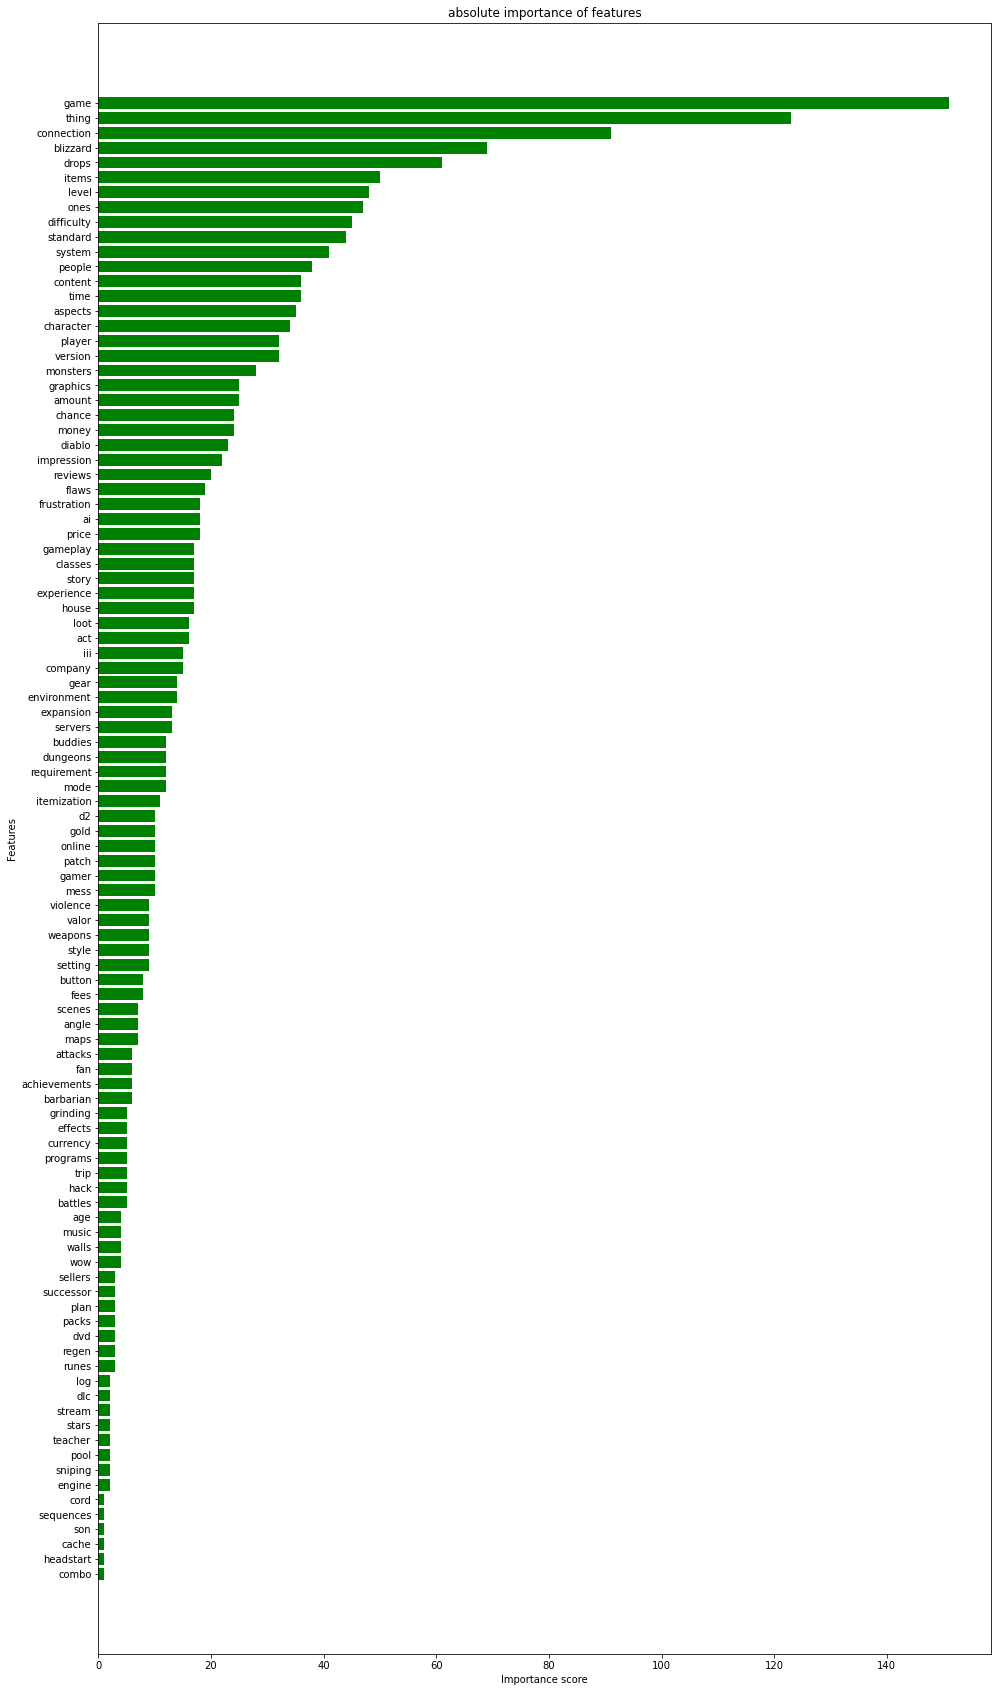

In [13]:
x = []
y= []


for item in sorted(labels.items(), key=lambda x: x[1][1], reverse=False):
    x.append(item[1][0])
    y.append(item[1][1])
    
x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(16,30))
plt.barh(x_pos, y, color='green')
plt.ylabel("Features")
plt.xlabel("Importance score")
plt.title("absolute importance of features")

plt.yticks(x_pos, x)

plt.show()